# Navier-Stokes方程反问题

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.1/resource/_static/logo_notebook.svg)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/r2.1/mindflow/zh_cn/physics_driven/mindspore_navier_stokes_inverse.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.1/resource/_static/logo_download_code.svg)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/r2.1/mindflow/zh_cn/physics_driven/mindspore_navier_stokes_inverse.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.1/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/r2.1/docs/mindflow/docs/source_zh_cn/physics_driven/navier_stokes_inverse.ipynb)

本案例要求**MindSpore版本 >= 2.0.0**调用如下接口: *mindspore.jit，mindspore.jit_class，mindspore.jacrev*。

## 概述

Navier-Stokes方程是一组描述流体力学中流体速度和压力变化的偏微分方程。Navier-Stokes的反问题是指，在已知某些流体运动特征（如流量、速度等）的条件下，求解出能够产生这些运动特征的流体性质（如黏度、密度等）和流体边界条件（如壁面摩擦力等）的问题。与正问题（即已知流体性质和边界条件，求解流体的运动特征）不同，反问题的解决需要通过数值优化和逆推算法等方法进行求解。

Navier-Stokes的反问题在工程和科学计算中具有广泛的应用，例如在航空、能源、地质、生物等领域中，可以用于优化流体设计、预测流体运动、诊断流体问题等。尽管Navier-Stokes的反问题非常具有挑战性，但是近年来随着计算机技术和数值方法的发展，已经取得了一定的进展。例如，可以通过使用高性能计算和基于机器学习的逆推算法等技术，加速反问题的求解过程，并提高求解精度。

## 问题描述

与Navier-Stokes方程不同的是，在Navier-Stokes方程反问题中，存在两个未知的参数。Navier-Stokes方程的反问题形式如下：

$$
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
$$

$$
\frac{\partial u} {\partial t} + \theta_1 (u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y}) = - \frac{\partial p}{\partial x} + \theta_2 (\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2})
$$

$$
\frac{\partial v} {\partial t} + \theta_1 (u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y}) = - \frac{\partial p}{\partial y} + \theta_2 (\frac{\partial^2v}{\partial x^2} + \frac{\partial^2v}{\partial y^2})
$$

其中 $\theta 1$ 和 $\theta 2$ 是未知的参数。

本案例利用PINNs方法学习位置和时间到相应流场物理量的映射，求解两个参数。

## 技术路径

MindSpore Flow求解该问题的具体流程如下：

1. 创建数据集。
2. 构建模型。
3. 优化器。
4. InvNavierStokes。
5. 模型训练。
6. 模型推理及可视化

In [1]:
import time

import numpy as np

import mindspore
from mindspore import context, nn, ops, jit, set_seed, load_checkpoint, load_param_into_net

下述 `src` 包可以在[applications/physics_driven/inverse_navier_stokes/src](https://gitee.com/mindspore/mindscience/tree/r0.3/MindFlow/applications/physics_driven/navier_stokes_inverse/src) 下载。

In [2]:
from mindflow.cell import MultiScaleFCSequential
from mindflow.utils import load_yaml_config
from mindflow.pde import sympy_to_mindspore, PDEWithLoss
from mindflow.loss import get_loss_metric

from src import create_training_dataset, create_test_dataset, calculate_l2_error

set_seed(123456)
np.random.seed(123456)

下述`inverse_navier_stokes.yaml`文件可以在[applications/physics_driven/inverse_navier_stokes/navier_stokes_inverse.yaml](https://gitee.com/mindspore/mindscience/blob/r0.3/MindFlow/applications/physics_driven/navier_stokes_inverse/navier_stokes_inverse.yaml)下载。

In [3]:
# set context for training: using graph mode for high performance training with GPU acceleration
config = load_yaml_config('inverse_navier_stokes.yaml')
context.set_context(mode=context.GRAPH_MODE, device_target="GPU", device_id=0)
use_ascend = context.get_context(attr_key='device_target') == "Ascend"

## 创建数据集

在本案例中，训练数据和测试数据均从[原数据](https://github.com/maziarraissi/PINNs/blob/master/main/Data/cylinder_nektar_wake.mat)中取样得到。

下载训练与测试数据集：[physics_driven/inverse_navier_stokes/dataset](https://download.mindspore.cn/mindscience/mindflow/dataset/applications/physics_driven/inverse_navier_stokes/dataset)。

In [4]:
# create dataset
inv_ns_train_dataset = create_training_dataset(config)
train_dataset = inv_ns_train_dataset.create_dataset(batch_size=config["train_batch_size"],
                                                    shuffle=True,
                                                    prebatched_data=True,
                                                    drop_remainder=True)
# create  test dataset
inputs, label = create_test_dataset(config)

./inverse_navier_stokes/dataset
get dataset path: ./inverse_navier_stokes/dataset
check eval dataset length: (40, 100, 50, 3)


## 构建模型

本示例使用一个简单的全连接网络，深度为6层，激活函数是`tanh`函数，每层有20个神经元。

In [5]:
coord_min = np.array(config["geometry"]["coord_min"] + [config["geometry"]["time_min"]]).astype(np.float32)
coord_max = np.array(config["geometry"]["coord_max"] + [config["geometry"]["time_max"]]).astype(np.float32)
input_center = list(0.5 * (coord_max + coord_min))
input_scale = list(2.0 / (coord_max - coord_min))

model = MultiScaleFCSequential(in_channels=config["model"]["in_channels"],
                               out_channels=config["model"]["out_channels"],
                               layers=config["model"]["layers"],
                               neurons=config["model"]["neurons"],
                               residual=config["model"]["residual"],
                               act='tanh',
                               num_scales=1,
                               input_scale=input_scale,
                               input_center=input_center)

## 优化器

在构建优化器时，两个未知参数与模型的参数一起放入优化器中训练。

In [6]:
if config["load_ckpt"]:
    param_dict = load_checkpoint(config["load_ckpt_path"])
    load_param_into_net(model, param_dict)

theta = mindspore.Parameter(mindspore.Tensor(np.array([0.0, 0.0]).astype(np.float32)), name="theta", requires_grad=True)
params = model.trainable_params()
params.append(theta)
optimizer = nn.Adam(params, learning_rate=config["optimizer"]["initial_lr"])

## InvNavierStokes

下述`inv_Navier_Stokes` 方程定义了这个反问题,包含两个部分：控制方程和训连数据。

In [7]:
from sympy import diff, Function, symbols
from mindspore import numpy as mnp

class InvNavierStokes(PDEWithLoss):
    r"""
    2D inverse NavierStokes equation problem based on PDEWithLoss.

    Args:
        model (mindspore.nn.Cell): network for training.
        params(mindspore.Tensor): parameter needs training
        loss_fn (Union[str, Cell]): Define the loss function. Default: mse.

    Supported Platforms:
        ``Ascend`` ``GPU``
    """

    def __init__(self, model, params, loss_fn="mse"):

        self.params_val = params[-1]
        self.theta1, self.theta2 = symbols('theta1 theta2')
        self.x, self.y, self.t = symbols('x y t')
        self.u = Function('u')(self.x, self.y, self.t)
        self.v = Function('v')(self.x, self.y, self.t)
        self.p = Function('p')(self.x, self.y, self.t)

        self.in_vars = [self.x, self.y, self.t]
        self.out_vars = [self.u, self.v, self.p]
        self.params = [self.theta1, self.theta2]

        super(InvNavierStokes, self).__init__(model, self.in_vars, self.out_vars, self.params, self.params_val)
        self.data_nodes = sympy_to_mindspore(self.data_loss(), self.in_vars, self.out_vars)
        if isinstance(loss_fn, str):
            self.loss_fn = get_loss_metric(loss_fn)
        else:
            self.loss_fn = loss_fn

    def pde(self):
        """
        Define governing equations based on sympy, abstract method.

        Returns:
            dict, user defined sympy symbolic equations.
        """
        momentum_x = self.u.diff(self.t) + \
                     self.theta1 * (self.u * self.u.diff(self.x) + self.v * self.u.diff(self.y)) + \
                     self.p.diff(self.x) - \
                     self.theta2 * (diff(self.u, (self.x, 2)) + diff(self.u, (self.y, 2)))
        momentum_y = self.v.diff(self.t) + \
                     self.theta1 * (self.u * self.v.diff(self.x) + self.v * self.v.diff(self.y)) + \
                     self.p.diff(self.y) - \
                     self.theta2 * (diff(self.v, (self.x, 2)) + diff(self.v, (self.y, 2)))
        continuty = self.u.diff(self.x) + self.v.diff(self.y)

        equations = {"momentum_x": momentum_x, "momentum_y": momentum_y, "continuty": continuty}
        return equations

    def data_loss(self):
        """
        Define governing equations based on sympy, abstract method.

        Returns:
            dict, user defined sympy symbolic equations.
        """
        velocity_u = self.u
        velocity_v = self.v
        p = self.p
        equations = {"velocity_u": velocity_u, "velocity_v": velocity_v, "p": p}
        return equations

    def get_loss(self, pde_data, data, label):
        """
        loss contains 2 parts,pde parts and data loss.
        """
        pde_res = self.parse_node(self.pde_nodes, inputs=pde_data)
        pde_residual = ops.Concat(1)(pde_res)
        pde_loss = self.loss_fn(pde_residual, mnp.zeros_like(pde_residual))

        data_res = self.parse_node(self.data_nodes, inputs=data)
        data_residual = ops.Concat(1)(data_res)
        train_data_loss = self.loss_fn(data_residual, label)

        return pde_loss + train_data_loss

## 模型训练

使用**MindSpore >= 2.0.0**的版本，可以使用函数式编程范式训练神经网络。

In [8]:
def train():
    problem = InvNavierStokes(model, params)
    if use_ascend:
        from mindspore.amp import DynamicLossScaler, auto_mixed_precision, all_finite
        loss_scaler = DynamicLossScaler(1024, 2, 100)
        auto_mixed_precision(model, 'O3')

    def forward_fn(pde_data, train_points, train_label):
        loss = problem.get_loss(pde_data, train_points, train_label)
        if use_ascend:
            loss = loss_scaler.scale(loss)
        return loss

    grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)

    @jit
    def train_step(pde_data, train_points, train_label):
        loss, grads = grad_fn(pde_data, train_points, train_label)
        if use_ascend:
            loss = loss_scaler.unscale(loss)
            if all_finite(grads):
                grads = loss_scaler.unscale(grads)
                loss = ops.depend(loss, optimizer(grads))
        else:
            loss = ops.depend(loss, optimizer(grads))
        return loss

    epochs = config["train_epochs"]
    steps_per_epochs = train_dataset.get_dataset_size()
    sink_process = mindspore.data_sink(train_step, train_dataset, sink_size=1)

    param1_hist = []
    param2_hist = []
    for epoch in range(1, 1 + epochs):
        # train
        time_beg = time.time()
        model.set_train(True)
        for _ in range(steps_per_epochs):
            step_train_loss = sink_process()
        print(f"epoch: {epoch} train loss: {step_train_loss} epoch time: {(time.time() - time_beg) * 1000 :.3f} ms")
        model.set_train(False)
        if epoch % config["eval_interval_epochs"] == 0:
        # if epoch % 10 ==0:
            print(f"Params are{params[-1].value()}")
            param1_hist.append(params[-1].value()[0])
            param2_hist.append(params[-1].value()[1])
            calculate_l2_error(model, inputs, label, config)

In [ ]:
start_time = time.time()
train()
print("End-to-End total time: {} s".format(time.time() - start_time))

momentum_x: theta1*u(x, y, t)*Derivative(u(x, y, t), x) + theta1*v(x, y, t)*Derivative(u(x, y, t), y) - theta2*Derivative(u(x, y, t), (x, 2)) - theta2*Derivative(u(x, y, t), (y, 2)) + Derivative(p(x, y, t), x) + Derivative(u(x, y, t), t)
    Item numbers of current derivative formula nodes: 6
momentum_y: theta1*u(x, y, t)*Derivative(v(x, y, t), x) + theta1*v(x, y, t)*Derivative(v(x, y, t), y) - theta2*Derivative(v(x, y, t), (x, 2)) - theta2*Derivative(v(x, y, t), (y, 2)) + Derivative(p(x, y, t), y) + Derivative(v(x, y, t), t)
    Item numbers of current derivative formula nodes: 6
continuty: Derivative(u(x, y, t), x) + Derivative(v(x, y, t), y)
    Item numbers of current derivative formula nodes: 2
velocity_u: u(x, y, t)
    Item numbers of current derivative formula nodes: 1
velocity_v: v(x, y, t)
    Item numbers of current derivative formula nodes: 1
p: p(x, y, t)
    Item numbers of current derivative formula nodes: 1
epoch: 100 train loss: 0.04028289 epoch time: 2229.404 ms
Param

## 模型推理及可视化

训练后可对流场内所有数据点进行推理，并可视化相关结果。

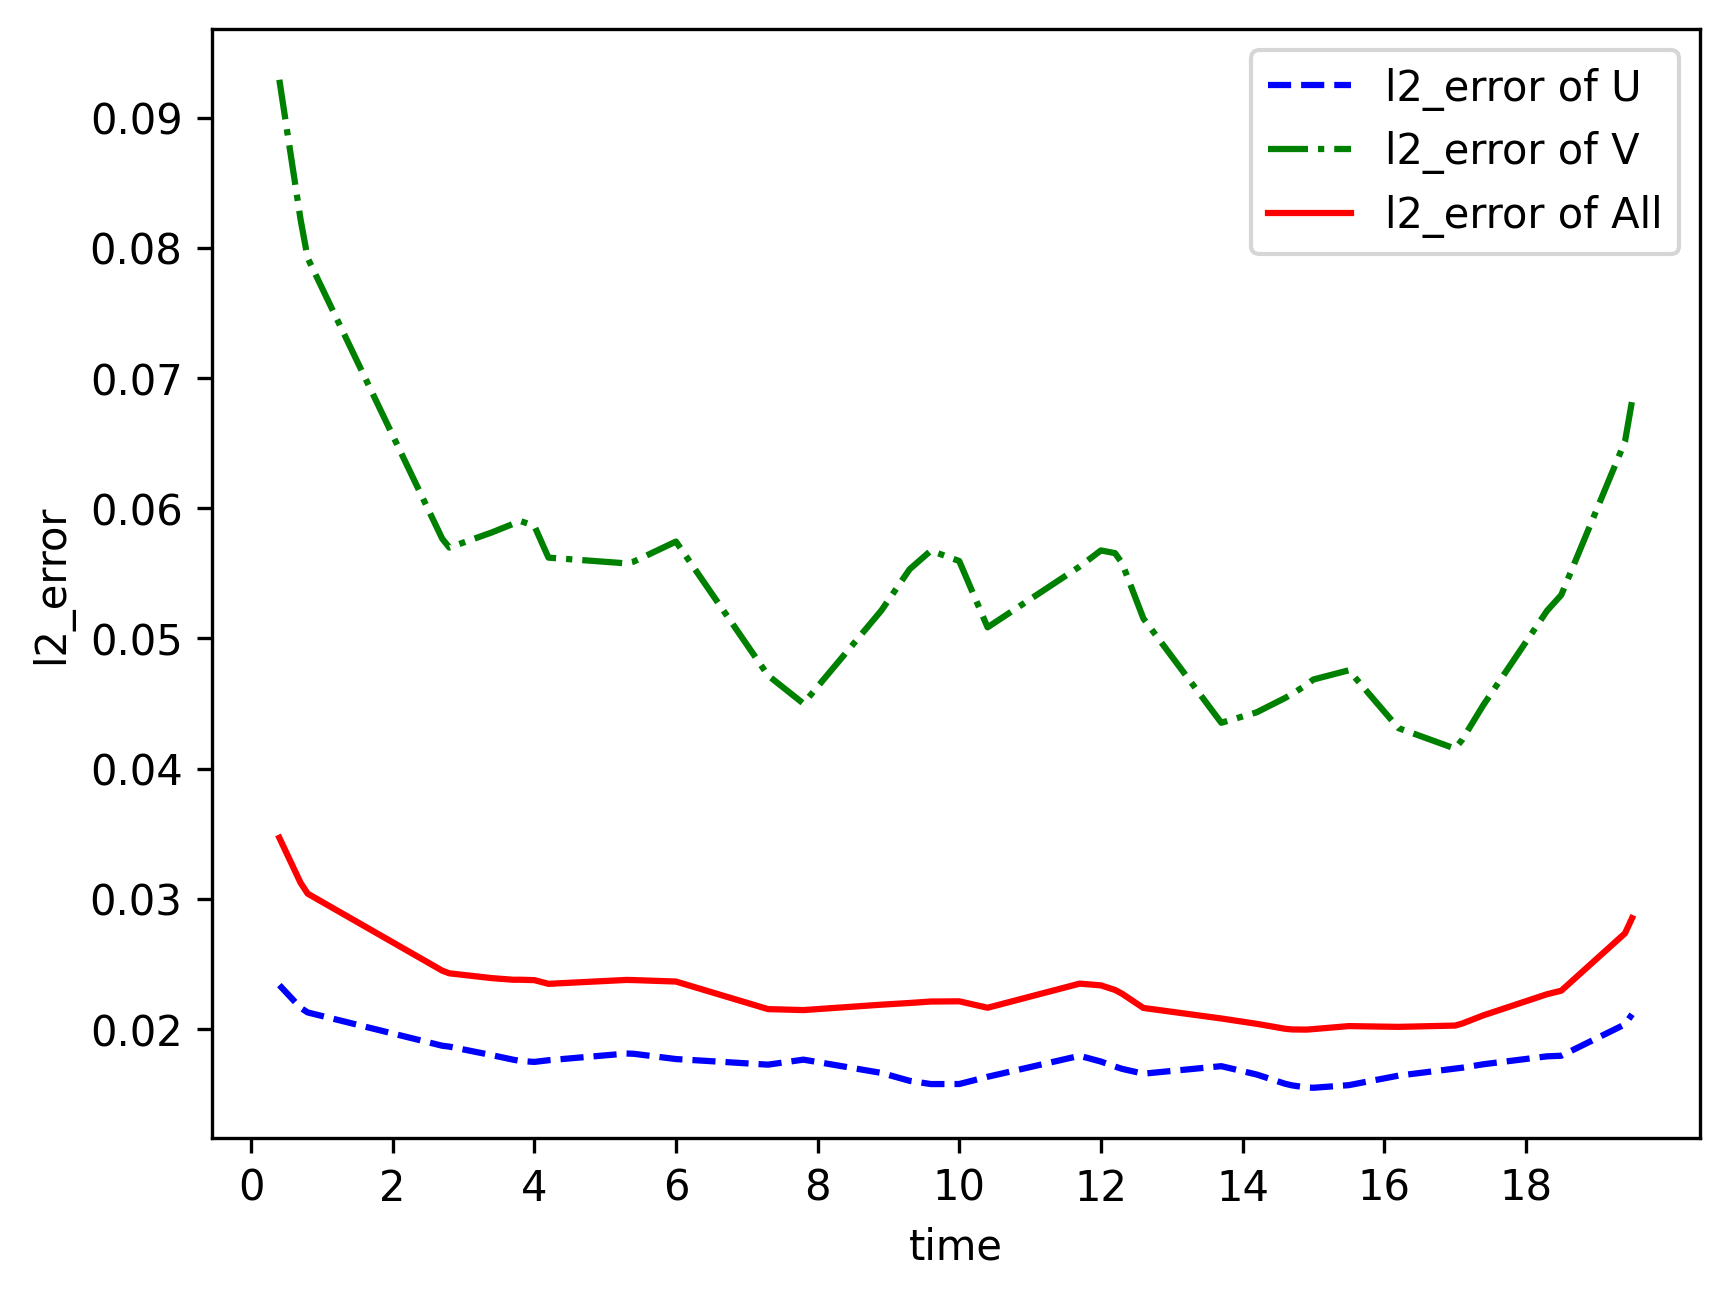

In [ ]:
from src import visual

# visualization
visual(model=model, epochs=config["train_epochs"], input_data=inputs, label=label)


Text(0, 0.5, 'value')

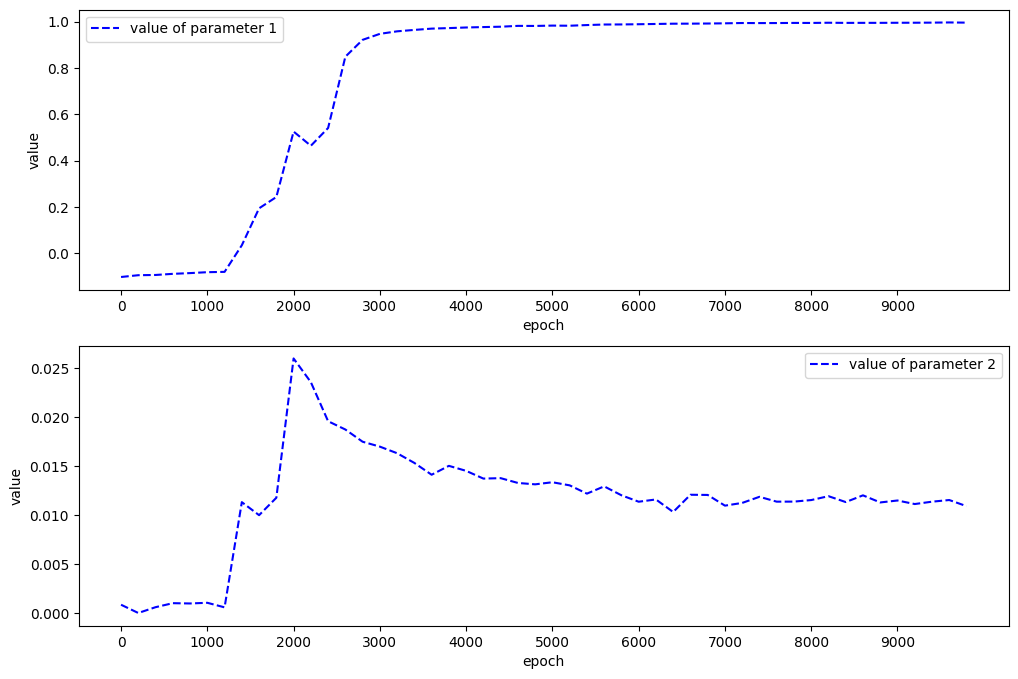

In [ ]:
from src import plot_params

plot_params(param1_hist, param2_hist)

在本案例中，$\theta_1$ 和 $\theta_2$ 的标准值分别为1和0.01。

Correct PDE:

- $u_t + (u u_x + v u_x) = - p_x + 0.01(u_{xx} + u_{yy})$

- $v_t + (u v_x + v v_x) = - p_y + 0.01(v_{xx} + v_{yy})$

Identified PDE:

- $u_t + 0.9984444(u u_x + v u_x) = - p_x + 0.01072927(u_{xx} + u_{yy})$

- $v_t + 0.9984444(u v_x + v v_x) = - p_y + 0.01072927(v_{xx} + v_{yy})$